<a href="https://colab.research.google.com/github/mariambouhlel/Container-Tracking-Data/blob/main/Container_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prédiction et analyse des délais de livraison des conteneurs de la Chine aux États-Unis

## Introduction

La délai logistique est un enjeu crucial pour les acteurs du transport maritime, un retard mal anticpé peut complètement perturber la supply chain. Dans ce projet, nous étudierons le parcours complet d'un conteneur de l'usine chinoise (ou asiatique) au client final américain (passsant par le port chinois, le port américain, et enfin, l'entrepôt américain). Un algorithme de prédiction existe déjà, mais notre but est d'en implémenter un plus performant.

## Importation des librairies pertinentes

In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datetime as dt

In [139]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [140]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [198]:
from sklearn.pipeline import make_pipeline

## Importation et description des données

In [141]:
df = pd.read_excel('/content/Container Tracking Data.xlsx')

In [142]:
display(df)

,CONTAINER_NUMBER,VESSEL_NAME,FREIGHT_FORWARDER,PLACE_OF_DISPATCH,PORT_OF_LOADING,PORT_OF_DISCHARGE,POST_PORT_OF_DISCHARGE,PLACE_OF_DISPATCH_DATE,PORT_OF_LOADING_DATE,PORT_OF_DISCHARGE_DATE,POST_PORT_OF_DISCHARGE_DATE,PREDICTED_DELIVERED_DATE,LAST_TRACKED_WITH_VESSEL,DELIVERED_FLAG,DELIVERED_DATE,Another NEW Predicated Delivery Date
0,FCIU8573349,CAPE SOUNIO,CIF,"Yantian, Guangdong Sheng, China","Yantian, Guangdong Sheng, China","Long Beach, California, United States","Dallas, Texas, United States",2021-05-18,2021-05-19 00:00:00,2021-07-17,2021-07-15,2021-08-03,2021-08-03,Yes,2021-07-21,?
1,TGBU9903815,CAPE SOUNIO,CIF,"Yantian, Guangdong Sheng, China","Yantian, Guangdong Sheng, China","Long Beach, California, United States","Dallas, Texas, United States",2021-05-18,2021-05-19 00:00:00,2021-07-23,2021-07-21,2021-08-09,2021-07-26,Yes,2021-07-27,?
2,TCNU3242533,OOCL LUXEMBOURG,Axiom,"Shanghai, Shanghai Shi, China","Shanghai, Shanghai Shi, China","Long Beach, California, United States","Gainesville, Texas, United States",2021-04-11,2021-04-17 00:00:00,2021-05-05,2021-06-07,2021-06-11,2021-06-20,Yes,2021-06-16,?
3,FCIU8623774,MSC ORION,LF,"Vung Tau, Tinh Ba Ria-Vung Tau, Vietnam","Ho Chi Minh City, Ho Chi Minh City, Vietnam","Long Beach, California, United States","Dallas, Texas, United States",2021-05-19,2021-05-20 00:00:00,2021-07-15,2021-07-12,2021-07-19,2021-08-24,Yes,2021-07-20,?
4,FCIU9776905,COSCO ENGLAND,CIF,"Yantian, Guangdong Sheng, China","Yantian, Guangdong Sheng, China","Long Beach, California, United States","Gainesville, Texas, United States",2021-05-18,2021-05-24 00:00:00,2021-06-11,2021-06-22,2021-06-26,2021-06-26,Yes,2021-06-28,?
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,FSCU6353914,PEARL RIVER BRIDGE,JAS,"Chattogram, Chittagong, Bangladesh","Chattogram, Chittagong, Bangladesh","Los Angeles, California, United States","Dallas, Texas, United States",2021-11-11,2021-11-15 00:00:00,2022-02-16,2022-02-27,2022-03-03,2022-02-16,NaN,NaT,?
1826,MAGU5225236,CSCL YELLOW SEA,Art Time,"Tianjin Xingang, Tianjin Shi, China","Tianjin Xingang, Tianjin Shi, China","Long Beach, California, United States","Dallas, Texas, United States",2022-01-09,2022-01-13 00:00:00,2022-03-12,2022-03-06,2022-03-29,2022-02-18,NaN,NaT,?
1827,BEAU4698279,AS SARA,LF,"Ho Chi Minh City, Ho Chi Minh City, Vietnam","Cai Mep, Tinh Ba Ria-Vung Tau, Vietnam","Long Beach, California, United States","Dallas, Texas, United States",2022-01-30,2022-02-01 00:00:00,2022-03-01,2022-03-08,2022-03-12,2022-02-18,NaN,NaT,?
1828,CAIU9631734,CSCL SUMMER,YUEHSNEG,"Tianjin Xingang, Tianjin Shi, China","Tianjin Xingang, Tianjin Shi, China","Dallas, Texas, United States","Dallas, Texas, United States",2021-12-21,2021-12-29 00:00:00,2022-03-29,2022-02-18,2022-02-18,2022-02-15,NaN,NaT,?


In [143]:
df.head()

,CONTAINER_NUMBER,VESSEL_NAME,FREIGHT_FORWARDER,PLACE_OF_DISPATCH,PORT_OF_LOADING,PORT_OF_DISCHARGE,POST_PORT_OF_DISCHARGE,PLACE_OF_DISPATCH_DATE,PORT_OF_LOADING_DATE,PORT_OF_DISCHARGE_DATE,POST_PORT_OF_DISCHARGE_DATE,PREDICTED_DELIVERED_DATE,LAST_TRACKED_WITH_VESSEL,DELIVERED_FLAG,DELIVERED_DATE,Another NEW Predicated Delivery Date
0,FCIU8573349,CAPE SOUNIO,CIF,"Yantian, Guangdong Sheng, China","Yantian, Guangdong Sheng, China","Long Beach, California, United States","Dallas, Texas, United States",2021-05-18,2021-05-19 00:00:00,2021-07-17,2021-07-15,2021-08-03,2021-08-03,Yes,2021-07-21,?
1,TGBU9903815,CAPE SOUNIO,CIF,"Yantian, Guangdong Sheng, China","Yantian, Guangdong Sheng, China","Long Beach, California, United States","Dallas, Texas, United States",2021-05-18,2021-05-19 00:00:00,2021-07-23,2021-07-21,2021-08-09,2021-07-26,Yes,2021-07-27,?
2,TCNU3242533,OOCL LUXEMBOURG,Axiom,"Shanghai, Shanghai Shi, China","Shanghai, Shanghai Shi, China","Long Beach, California, United States","Gainesville, Texas, United States",2021-04-11,2021-04-17 00:00:00,2021-05-05,2021-06-07,2021-06-11,2021-06-20,Yes,2021-06-16,?
3,FCIU8623774,MSC ORION,LF,"Vung Tau, Tinh Ba Ria-Vung Tau, Vietnam","Ho Chi Minh City, Ho Chi Minh City, Vietnam","Long Beach, California, United States","Dallas, Texas, United States",2021-05-19,2021-05-20 00:00:00,2021-07-15,2021-07-12,2021-07-19,2021-08-24,Yes,2021-07-20,?
4,FCIU9776905,COSCO ENGLAND,CIF,"Yantian, Guangdong Sheng, China","Yantian, Guangdong Sheng, China","Long Beach, California, United States","Gainesville, Texas, United States",2021-05-18,2021-05-24 00:00:00,2021-06-11,2021-06-22,2021-06-26,2021-06-26,Yes,2021-06-28,?


In [144]:
df.shape

(1830, 16)

In [145]:
df.dtypes

,0
CONTAINER_NUMBER,object
VESSEL_NAME,object
FREIGHT_FORWARDER,object
PLACE_OF_DISPATCH,object
PORT_OF_LOADING,object
PORT_OF_DISCHARGE,object
POST_PORT_OF_DISCHARGE,object
PLACE_OF_DISPATCH_DATE,datetime64[ns]
PORT_OF_LOADING_DATE,object
PORT_OF_DISCHARGE_DATE,datetime64[ns]


In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830 entries, 0 to 1829
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   CONTAINER_NUMBER                      1830 non-null   object        
 1   VESSEL_NAME                           1534 non-null   object        
 2   FREIGHT_FORWARDER                     1401 non-null   object        
 3   PLACE_OF_DISPATCH                     1521 non-null   object        
 4   PORT_OF_LOADING                       1577 non-null   object        
 5   PORT_OF_DISCHARGE                     1564 non-null   object        
 6   POST_PORT_OF_DISCHARGE                1507 non-null   object        
 7   PLACE_OF_DISPATCH_DATE                1581 non-null   datetime64[ns]
 8   PORT_OF_LOADING_DATE                  1581 non-null   object        
 9   PORT_OF_DISCHARGE_DATE                1494 non-null   datetime64[ns]
 10  

Comme brièvement expliqué dans l'introduction, le parcours du conteneur se décompose en plusieurs étapes :

1. Départ depuis l'usine en Chine ('PLACE_OF_DISPATCH' à la date 'PLACE_OF_DISPATCH_DATE')
2. Transport terrestre de l'usine au port chinois ('PORT_OF_LOADING' à la date 'PORT_OF LOADING_DATE')
3. Traversée maritime de la Chine aux États-Unis (impliquant l'identification d'un navire le transportant 'VESSEL_NAME')
4. Arrivée au port américain ('PORT_OF_DISCHARGE' à la date 'PORT_OF_DISCHARGE_DATE')
5. Transport terrestre du port à l'entrepôt américain ('POST_PORT_OF_DISCHARGE' à la date 'POST_PORT_OF_DISCHARGE_DATE')
6. Arrivée chez le client final (à la date 'DELIVERED_DATE')

## Détection des incohérence dans les données

Cette étape dans le traitement des données est cruciale car les données sont rarement saisies sans erreur, il est donc necessaire d'identifier les NaN, les oublis de saisie, les incohérences, etc.

In [235]:
# Regardons le nombre de données manquantes pour chaque catégorie
np.sum(df.isna())

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,0
CONTAINER_NUMBER,0
VESSEL_NAME,46
FREIGHT_FORWARDER,39
PLACE_OF_DISPATCH,28
PORT_OF_LOADING,0
PORT_OF_DISCHARGE,4
POST_PORT_OF_DISCHARGE,17
PLACE_OF_DISPATCH_DATE,0
PORT_OF_LOADING_DATE,0
PORT_OF_DISCHARGE_DATE,38


Pour le nettoyage des données, nous supprimerons les lignes dont la date de livraison 'DELIVERED_DATE' est inconnue

In [236]:
df = df.dropna(axis=0, subset=['DELIVERED_DATE'])

In [237]:
# Vérifions le nombre de données manquantes
np.sum(df.isna())

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,0
CONTAINER_NUMBER,0
VESSEL_NAME,46
FREIGHT_FORWARDER,39
PLACE_OF_DISPATCH,28
PORT_OF_LOADING,0
PORT_OF_DISCHARGE,4
POST_PORT_OF_DISCHARGE,17
PLACE_OF_DISPATCH_DATE,0
PORT_OF_LOADING_DATE,0
PORT_OF_DISCHARGE_DATE,38


Les lignes inexploitables (celles dont la date réelle de livraison est inconnue) ont bien été supprimées. Intéressons-nous maintenant aux données incohérentes, notamment les dates telles que la date de l'étape n est plus tardive que la date de l'étape n+1

Convertissons d'abord toutes nos colonnes dont le contenu est une date au format datetime

In [238]:
df['PLACE_OF_DISPATCH_DATE'] = pd.to_datetime(df['PLACE_OF_DISPATCH_DATE'])
df['PORT_OF_LOADING_DATE'] = pd.to_datetime(df['PORT_OF_LOADING_DATE'])
df['PORT_OF_DISCHARGE_DATE'] = pd.to_datetime(df['PORT_OF_DISCHARGE_DATE'])
df['POST_PORT_OF_DISCHARGE_DATE'] = pd.to_datetime(df['POST_PORT_OF_DISCHARGE_DATE'])
df['DELIVERED_DATE'] = pd.to_datetime(df['DELIVERED_DATE'])
df['PREDICTED_DELIVERED_DATE'] = pd.to_datetime(df['PREDICTED_DELIVERED_DATE'])

Supprimons les lignes telles que PLACE_OF_DISPATCH_DATE > PORT_OF_LOADING_DATE, PORT_OF_LOADING_DATE > PORT_OF_DISCHARGE_DATE, PORT_OF_DISCHARGE_DATE > POST_PORT_OF_DISCHARGE_DATE, POST_PORT_OF_DISCHARGE_DATE > DELIVERED_DATE

In [239]:
df = df[~(df['PLACE_OF_DISPATCH_DATE'] > df['PORT_OF_LOADING_DATE'])]
df = df[~(df['PORT_OF_LOADING_DATE'] > df['PORT_OF_DISCHARGE_DATE'])]
df = df[~(df['PORT_OF_DISCHARGE_DATE'] > df['POST_PORT_OF_DISCHARGE_DATE'])]
df = df[~(df['POST_PORT_OF_DISCHARGE_DATE'] > df['DELIVERED_DATE'])]


Supprimons également les lignes telles que PLACE_OF_DISPATCH_DATE < DELIVERED_DATE

In [240]:
df = df[~(df['PLACE_OF_DISPATCH_DATE'] > df['DELIVERED_DATE'])]

De plus, d'après les documentations de compagnies maritimes telles que CMA CGM, une traversée maritime de la Chine aux États-Unis peut être prolongée jusqu'à 100 jours, toute valeur au-delà doit donc être considérée comme incohérente (https://cargoholidays.com/fr/cargo-ship-travel-time-from-china-to-us#:~:text=Les%20compagnies%20de%20fret%20telles%20que%20CMA%2DCGM%20et%20Hamburg%20Sud%20proposent%20des%20travers%C3%A9es%20prolong%C3%A9es%20pouvant%20aller%20jusqu%27%C3%A0%20100%20jours). Ainsi, les lignes telles que DELIVERED_DATE - PLACE_OF_DISPATCH_DATE > 100 sont absurdes

In [241]:
(df['DELIVERED_DATE'] - df['PLACE_OF_DISPATCH_DATE']).shape

(626,)

In [242]:
df = df[~((df['DELIVERED_DATE'] - df['PLACE_OF_DISPATCH_DATE']).dt.days > 100)]

Après visualisation de la différence (df['DELIVERED_DATE'] - df['POST_PORT_OF_DISCHARGE_DATE']).dt.days, nous constatons des valeurs aberrantes, ainsi, par soucis de cohérence, appliquons le même critère.

In [243]:
df = df[~((df['DELIVERED_DATE'] - df['POST_PORT_OF_DISCHARGE_DATE']).dt.days > 100)]

In [244]:
df.shape

(626, 21)

Nous constatons que seulement 810 lignes sur les 1830 initiales ont été conservées, cela signifie que sur 1830 conteneurs suivis, seuls 810 ont été suivis correctement du début à la fin

In [245]:
# Vérifions si ce jeu de données présente des doublons
df.duplicated().sum()

np.int64(0)

Aucun doublon, maintenant, calculons le délai entre chaque étape de la livraison.

## Analyse des données

Afin de meiux comprendre l'origine des retards, intéressons-nous à chaque phase du transport du conteneur. Pour ce faire, calculons les délais entre chaque étape (en jours).

In [159]:
# Délai usine chinoise → port chinois
delai_chine = (df['PORT_OF_LOADING_DATE']-df['PLACE_OF_DISPATCH_DATE']).dt.days

In [160]:
# Délai port chinois → port américain
delai_port = (df['PORT_OF_DISCHARGE_DATE']-df['PORT_OF_LOADING_DATE']).dt.days

In [161]:
# Délai port américain → entrepôt américan
delai_usa = (df['POST_PORT_OF_DISCHARGE_DATE']-df['PORT_OF_DISCHARGE_DATE']).dt.days

In [162]:
# Délai entrepôt américain → client (dernière étape)
delai_client = (df['DELIVERED_DATE']-df['POST_PORT_OF_DISCHARGE_DATE']).dt.days

In [163]:
# Délai de livraison total (qui est aussi la somme de tous les délais calculés)
delai_livraison = (df['DELIVERED_DATE']-df['PLACE_OF_DISPATCH_DATE']).dt.days

Intéressons-nous d'abord au comportement global du système logistique.

In [164]:
delai_livraison.describe()

,0
count,626.000000
mean,56.012780
std,15.780084
min,6.000000
25%,44.000000
50%,54.000000
75%,65.750000
max,99.000000


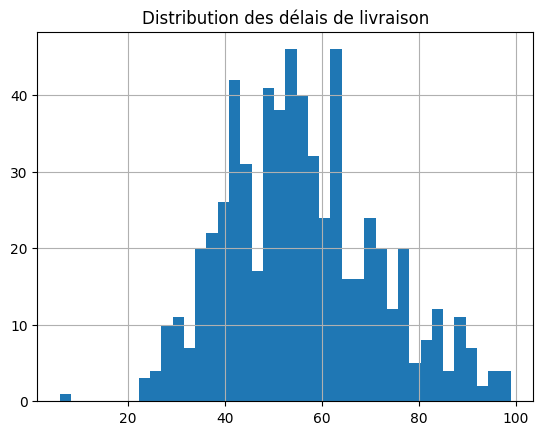

In [165]:
delai_livraison.hist(bins=40)
plt.title("Distribution des délais de livraison")
plt.show()

Le délai total moyen est de 56 jours soit près de 2 mois.

Regardons maintenant étape par étape, délai par délai, afin d'identifier quelles sont les étapes les plus chronophages.

In [166]:
delai_chine.describe()

,0
count,626.000000
mean,5.022364
std,5.532983
min,0.000000
25%,0.000000
50%,4.000000
75%,7.000000
max,34.000000


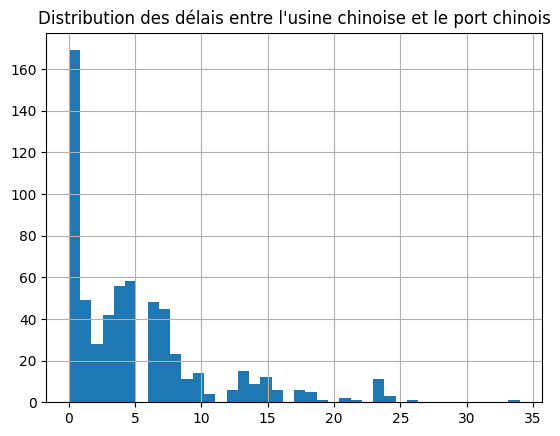

In [167]:
delai_chine.hist(bins=40)
plt.title("Distribution des délais entre l'usine chinoise et le port chinois")
plt.show()

In [168]:
delai_port.describe()

,0
count,588.000000
mean,35.054422
std,16.216500
min,12.000000
25%,21.000000
50%,31.000000
75%,47.000000
max,88.000000


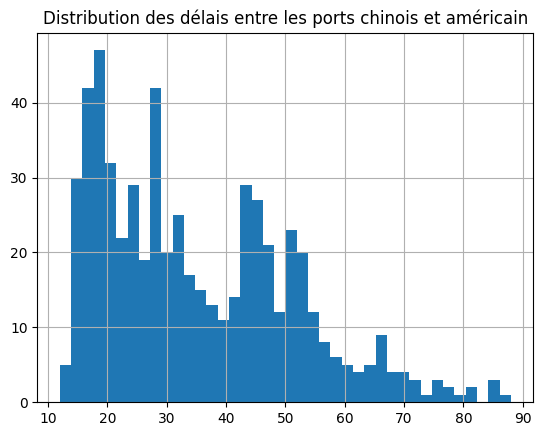

In [169]:
delai_port.hist(bins=40)
plt.title("Distribution des délais entre les ports chinois et américain")
plt.show()

In [170]:
delai_usa.describe()

,0
count,529.000000
mean,10.134216
std,7.405141
min,0.000000
25%,6.000000
50%,8.000000
75%,11.000000
max,41.000000


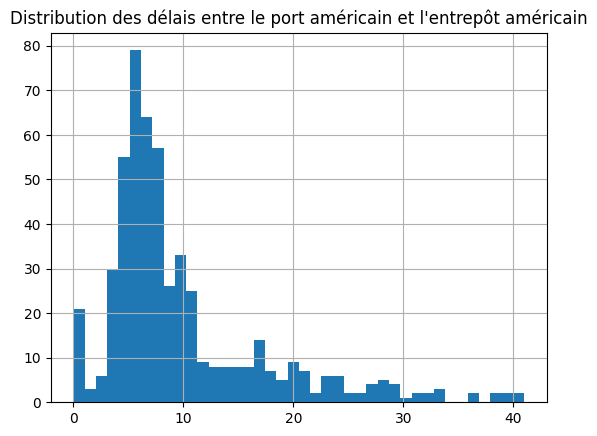

In [171]:
delai_usa.hist(bins=40)
plt.title("Distribution des délais entre le port américain et l'entrepôt américain")
plt.show()

In [172]:
delai_client.describe()

,0
count,568.000000
mean,5.088028
std,4.665835
min,0.000000
25%,2.750000
50%,4.000000
75%,6.250000
max,61.000000


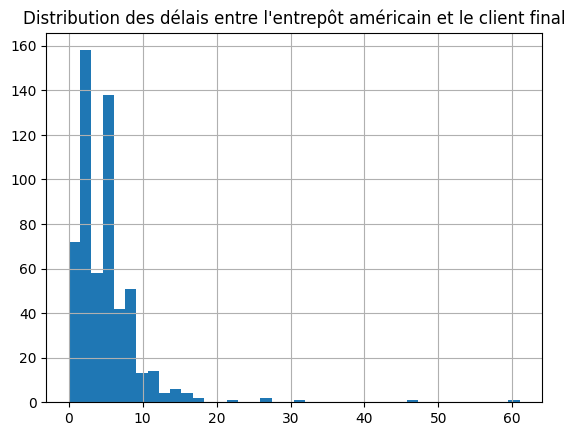

In [173]:
delai_client.hist(bins=40)
plt.title("Distribution des délais entre l'entrepôt américain et le client final")
plt.show()

Identifions maintenant, à partir des moyennes respectives des délais, quelle étape est la plus chronophage.


In [174]:
df['DELAI_CHINE'] = delai_chine
df['DELAI_PORT'] = delai_port
df['DELAI_USA'] = delai_usa
df['DELAI_CLIENT'] = delai_client

df[['DELAI_CHINE', 'DELAI_PORT', 'DELAI_USA', 'DELAI_CLIENT']].mean()

,0
DELAI_CHINE,5.022364
DELAI_PORT,35.054422
DELAI_USA,10.134216
DELAI_CLIENT,5.088028


Nous constatons que l'étape la plus chronophage est, sans surprise, la phase de traversée du conteneur, du port chinois au port américain.

Intéressons-nous maintenant aux ports (de départ PORT_OF_LOADING puis de décharge PORT_OF_DISCHARGE) afin d'identifier quels ports créent les retards.

In [175]:
df_depart = df.groupby('PORT_OF_LOADING')['DELAI_PORT'].mean().sort_values(ascending=False)

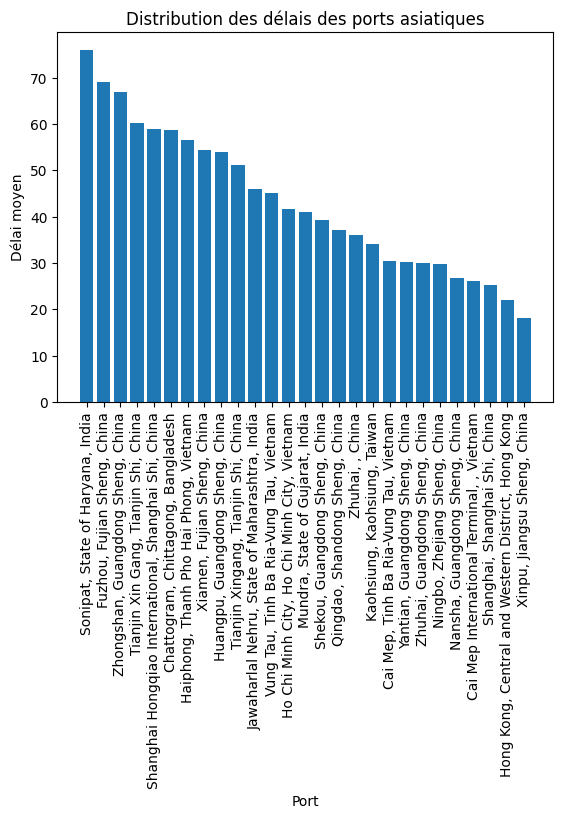

In [176]:
plt.bar(df_depart.index, df_depart.values)
plt.title('Distribution des délais des ports asiatiques')
plt.xlabel('Port')
plt.ylabel('Délai moyen')
plt.xticks(rotation=90)
plt.show()

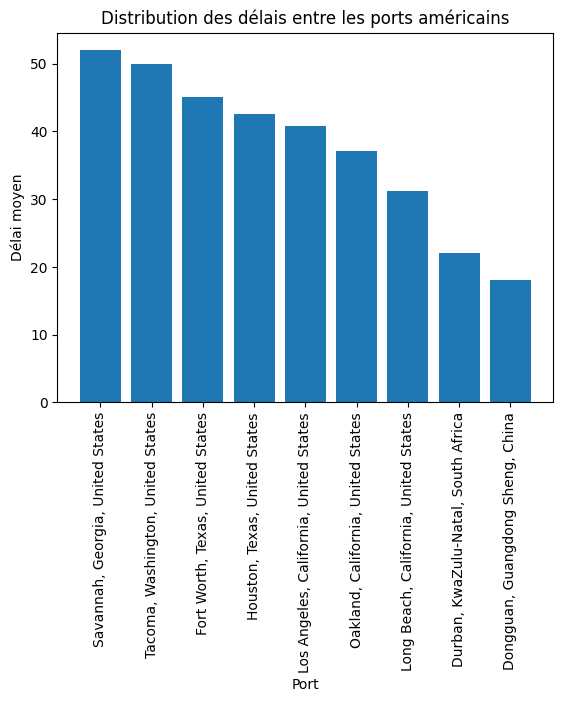

In [177]:
df_arrivee = df.groupby('PORT_OF_DISCHARGE')['DELAI_PORT'].mean().sort_values(ascending=False)
plt.bar(df_arrivee.index, df_arrivee.values)
plt.title('Distribution des délais entre les ports américains')
plt.xlabel('Port')
plt.ylabel('Délai moyen')
plt.xticks(rotation=90)
plt.show()

Les ports créant le plus de retards sont celui de Sonipat en Inde et celui de Savannah dans l'État de Géorgie. Intéressons-nous maintenant aux différents navires, susecptibles de poser problème. Compte tenu du grand nombres de navires différents, nous nous intéresserons qu'aux 35 premiers.

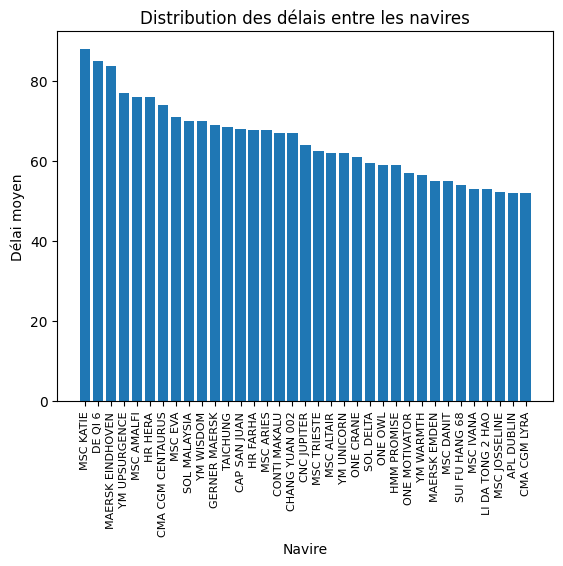

In [178]:
df_navire = df.groupby('VESSEL_NAME')['DELAI_PORT'].mean().sort_values(ascending=False).head(35)
plt.bar(df_navire.index, df_navire.values)
plt.title('Distribution des délais entre les navires')
plt.xlabel('Navire')
plt.ylabel('Délai moyen')
plt.xticks(rotation=90, fontsize=8)
plt.show()

Le navire créant le plus de retard est le MSC KATIE.

## Évaluation de la performance de l'algorithme de prédiction déjà existant

Maintenant, intéressons-nous à l'erreur faite par le modèle prédictif déjà existant, autrement dit calculons la différence 'PREDICTED_DELEVERY_DATE'-'DELEVERY_DATE'. Notons que si cette différence est négative, la livraison a du retard, sinon, elle a de l'avance (ce qui peut être perçu comme un avantage bien que cela remette en cause la validité du modèle de prédiction).

In [179]:
erreur = (df['PREDICTED_DELIVERED_DATE']-df['DELIVERED_DATE']).dt.days
erreur.describe()

,0
count,735.000000
mean,-123.497959
std,2321.690812
min,-44550.000000
25%,-4.000000
50%,-1.000000
75%,0.000000
max,33.000000


Le minimum à -44550 (équivalent à 122 ans) est une erreur complètement absurde donc filtrons de nouveau l'erreur (ne gardant que les erreurs de valeur absolue 100)

In [180]:
erreur_filtre = erreur[(erreur>-100)&(erreur<100)]
erreur_filtre.describe()

,0
count,733.000000
mean,-2.306958
std,5.835862
min,-45.000000
25%,-4.000000
50%,-1.000000
75%,0.000000
max,33.000000


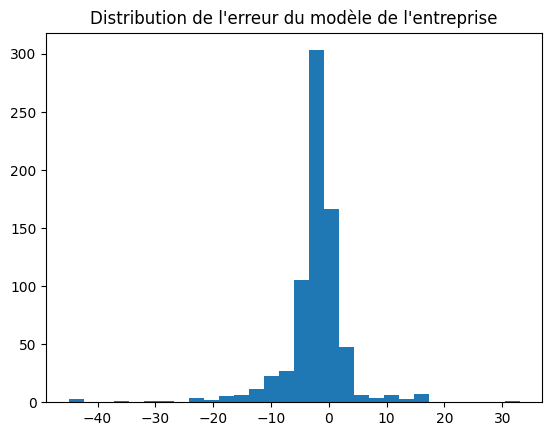

In [181]:
plt.hist(erreur_filtre, bins = 30)
plt.title("Distribution de l'erreur du modèle de l'entreprise")
plt.show()

La distribution est centrée aux alentours de zero, avec une moyenne de -2 et une erreur standard raisonabble. Cela signifie que l'algorithme est globalement précis mais comporte quelques erreurs extrêmes.

## Implémentation d'un nouveau modèle prédictif

À cette étape du projet, nous tenterons d'obtenir un modèle plus précis que celui déjà implémenté. Pour ce faire, nous ne prédirons pas une date mais un délai à partir des caractéristiques réelles du transport (ports, navire, etc. )

In [199]:
X = df[['PORT_OF_LOADING', 'PORT_OF_DISCHARGE', 'VESSEL_NAME', 'DELAI_CHINE', 'DELAI_PORT', 'DELAI_USA', 'DELAI_CLIENT']]

df['DELAI_LIVRAISON'] = delai_livraison
df = df.dropna(subset=['DELAI_LIVRAISON'])
y = df['DELAI_LIVRAISON']

Les variables 'PORT_OF_LOADING', 'PORT_OF_DISCHARGE' et 'VESSEL_NAME', n'étant pas des valeurs numériques mais textuelles, doivent être encodées.

In [187]:
X = pd.get_dummies(X, columns=['PORT_OF_LOADING', 'PORT_OF_DISCHARGE', 'VESSEL_NAME'])

Maintenant, séparons nos données en deux parties : 80% constituera le jeu de données d'entraînement et 20% celui destiné au test.

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Appliquons maintenant un modèle de régression par forêt aléatoire.

In [214]:
regressor = RandomForestRegressor(n_estimators=200, random_state=42)
model = regressor.fit(X_train, y_train)

In [215]:
predictions = regressor.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print(f'Erreur Absolue Moyenne: {mae}')

r2 = r2_score(y_test, predictions)
print(f'R2: {r2}')

Erreur Absolue Moyenne: 3.00669567271353
R2: 0.9093788738354102


Notre nouvel algorithme se trompe en moyenne de 3 jours.

## Comparaison des modèles

Comparons maintenant les résultats obtenus à ceux de l'ancien algorithme. Pour ce faire, créons un tableau de données subset_df pour pouvoir manipuler nos données plus aisément.

In [216]:
df_bis = df[['DELAI_LIVRAISON']].copy()
df_bis['ANCIEN_DELAI_LIVRAISON_PREDIT'] = (df['PREDICTED_DELIVERED_DATE']-df['PLACE_OF_DISPATCH_DATE']).dt.days
df_bis = df_subset.dropna() # Supprimons les éventuels NaN

In [217]:
df_bis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 620 entries, 2 to 1813
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DELAI_LIVRAISON                620 non-null    float64
 1   ANCIEN_DELAI_LIVRAISON_PREDIT  620 non-null    float64
dtypes: float64(2)
memory usage: 14.5 KB


In [218]:
mae_ancien = mean_absolute_error(df_bis['DELAI_LIVRAISON'], df_bis['ANCIEN_DELAI_LIVRAISON_PREDIT'])
print(f'Erreur Absolue Moyenne (ancien algorithme): {mae_ancien}')

r2_ancien = r2_score(df_bis['DELAI_LIVRAISON'], df_bis['ANCIEN_DELAI_LIVRAISON_PREDIT'])
print(f'R2 (ancien algorithme): {r2_ancien}')

Erreur Absolue Moyenne (ancien algorithme): 3.9370967741935483
R2 (ancien algorithme): 0.8282381113375301


Le modèle proposé permet de réduire l'erreur de prédiction d'un jour par rapport à l'algorithme déjà existant. Cette réduction d'un jour représente un gain non négligeable à l'échelle de milliers de conteneurs. Évaluons maintenant l'importance des variables de ce nouveau modèle.

## Identification des facteurs les plus déterminants

In [233]:
importances = model.feature_importances_
feature_scores = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

grouped_importance = {
    'PORT_OF_LOADING': feature_scores[feature_scores.index.str.startswith('PORT_OF_LOADING')].sum(),
    'PORT_OF_DISCHARGE': feature_scores[feature_scores.index.str.startswith('PORT_OF_DISCHARGE')].sum(),
    'VESSEL_NAME': feature_scores[feature_scores.index.str.startswith('VESSEL_NAME')].sum(),
    'DELAI_CHINE': feature_scores['DELAI_CHINE'],
    'DELAI_PORT': feature_scores['DELAI_PORT'],
    'DELAI_USA': feature_scores['DELAI_USA'],
    'DELAI_CLIENT': feature_scores['DELAI_CLIENT'],
}

grouped_importance = pd.Series(grouped_importance).sort_values(ascending=False)


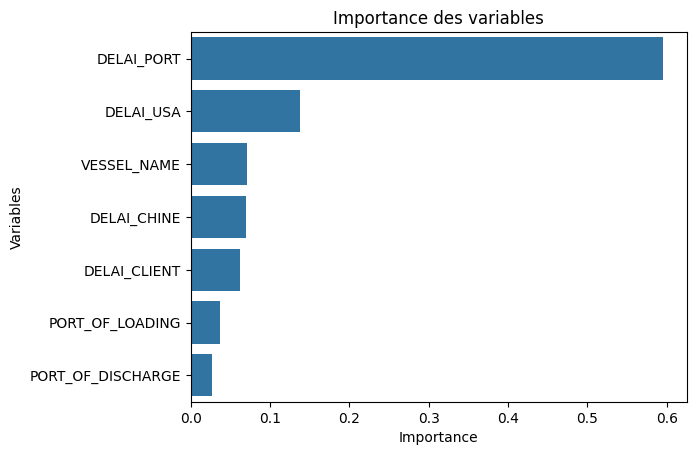

In [234]:
sns.barplot(x=grouped_importance.values, y=grouped_importance.index)
plt.title('Importance des variables')
plt.xlabel('Importance')
plt.ylabel('Variables')
plt.show()

Cette étude prouve que certains ports ralentissent le transport des conteneurs, de même pour certains navires et bien que la durée de la phase maritime soit la plus importante, les phases de transport terrestre peuvent aussi être problématiques.

## Conclusion

Cette étude montre qu'une meilleur exploitation des données de tracking des conteneurs permet d'améliorer nettement la prédiction des dates de livraison. De plus, au-delà du modèle prédictif, cette analyse met en évidence l'importance de la qualité des donénes, la compréhension des étapes logistiques, ainsi que l'identification des points critiques du transport. Ce type d'approche peut permettre aux entreprise maritimes d'anticiper les retards, et plus généralement, d'optimiser la chaîne logistique.